In [65]:
#Clear previous output and variables to ensure no mixing of the data
%reset -f

In [1]:
# Import Necessary Packages 
import os
import pandas as pd
import glob
import numpy as np

Functions

In [2]:
# Function (1) experiment_parameters(experiment_type, is_extreme)
# This function sets the global variables experiment and extreme based on user input.
# Inputs: experiment_type (str), is_extreme (bool)
# Outputs: experiment (str), extreme (bool)

def experiment_parameters(experiment_type, is_extreme):
    global experiment, extreme #declare global variables for experiment and extreme that will be used throughout the script
    
    if experiment_type == 'novel' and is_extreme == False: # Novel Glint Original version
        experiment = 'novel'
        extreme = False

    elif experiment_type == 'novel' and is_extreme == True: # Novel Glint Extreme version
        experiment = 'novel'
        extreme = True

    elif experiment_type == 'familiar' and is_extreme == False: # Familiar Glint Original version
        experiment = 'familiar'
        extreme = False

    elif experiment_type == 'familiar' and is_extreme == True: # Familiar Glint Extreme version
        experiment = 'familiar'
        extreme = True
    return experiment, extreme #returns the global variables experiment and extreme

# Function (2) paths_of_interest()
# This function sets the core path to the glint data based on the experiment and extreme variables
# Inputs: None (uses global variables experiment and extreme)
# Outputs: files (list of str) - list of file paths to csv files in the core path

def paths_of_interest():
    base = '/zpool/vladlab/data_drive/glint_data' # base path to glint data

    if experiment == 'familiar' and (extreme == False): # Familiar Glint Original version
        core_path = f'{base}/{experiment}_glint' # path to familiar glint data
        print("You have selected familiar glint experiment")
        files = glob.glob(f'{core_path}/*.csv') #get all csv files in the core path
    
    elif experiment == 'novel' and (extreme == False): # Novel Glint Original version
        core_path = f'{base}/{experiment}_glint' # path to novel glint data
        print("You have selected novel glint experiment")
        files = glob.glob(f'{core_path}/*.csv') #get all csv files in the core path

    elif experiment == 'familiar' and (extreme == True): # Familiar Glint Extreme version
        glint_version = 'extreme' #specify glint extreme version
        core_path = f'{base}/{experiment}_glint_{glint_version}' # path to familiar glint extreme data
        print("You have selected familiar glint extreme experiment")
        files = glob.glob(f'{core_path}/*.csv') #get all csv files in the core path
    
    elif experiment == 'novel' and (extreme == True): # Novel Glint Extreme version
        glint_version = 'extreme' #specify glint extreme version
        core_path = f'{base}/{experiment}_glint_{glint_version}' # path to novel glint extreme data
        print("You have selected novel glint extreme experiment")
        files = glob.glob(f'{core_path}/*.csv') #get all csv files in the core path
    return files #returns the list of files found in the specified core path

# Function (3) new_trial_version(data, condition, animacy_inclusion, animacy=None, stimulus_duration=None)
# This function filters the data frame based on the experiment type, extreme version, condition, animacy inclusion, animacy category, and stimulus duration.
# Inputs: data (DataFrame), condition (str), animacy_inclusion (bool), animacy (str, optional), stimulus_duration (float, optional)
# Outputs: trials (DataFrame) - filtered data frame based on the specified criteria

# As novel experiments all use the same animacy category (inanim_artificial), the animacy filter will not be applied for novel experiments.
def new_trial_version(data, condition, animacy_inclusion, animacy=None, stimulus_duration=None):
    trials = None  # Initialize to handle edge cases

    if animacy_inclusion == True:  # If animacy inclusion = True
        if experiment == 'familiar' and extreme == False: # If (1) familiar experiment, (2) extreme = False (e.g. original version), (3) animacy inclusion = True
            trials = data[(data['img_condition'] == condition) & (data['object_category'] == animacy)] #filters data frame for the condition of interest
        
        # This branch is unreachable as novel experiments have animacy_inclusion forced to False, just keeping for clarity 
        elif experiment == 'novel' and extreme == False:
            print('As novel images are all inanimate_artificial, animacy filter will not be applied.')
            return None # Exit the function or raise an error as animacy filter is not applicable for novel experiments
        
        elif experiment == 'familiar' and extreme == True:
            trials = data[(data['img_condition'] == condition) & (data['stimulus_duration'] == stimulus_duration) & (data['object_category'] == animacy)] #filters data frame for the condition of interest and stimulus duration

        # This branch is unreachable as novel experiments have animacy_inclusion forced to False, just keeping for clarity 
        elif experiment == 'novel' and extreme == True:
            print('As novel images are all inanimate_artificial, animacy filter will not be applied.')
            return None # Exit the function or raise an error as animacy filter is not applicable for novel experiments
    elif animacy_inclusion == False: #If animacy inclusion = False
        if experiment == 'familiar' and extreme == False:
            trials = data[data['img_condition'] == condition] #filters data frame for the condition of interest

        elif experiment == 'novel' and extreme == False:
            trials = data[data['condition'] == condition] #filters data frame for the condition of interest
    
        elif experiment == 'familiar' and extreme == True:
            trials = data[(data['img_condition'] == condition) & (data['stimulus_duration'] == stimulus_duration)] #filters data frame for the condition of interest and stimulus duration

        elif experiment == 'novel' and extreme == True:
            trials = data[(data['condition'] == condition) & (data['stimulus_duration'] == stimulus_duration)] #filters data frame for the condition of interest and stimulus duration
    if trials is None:
        print(f"Warning: No trials matched for condition={condition}, animacy_inclusion={animacy_inclusion}, experiment={experiment}, extreme={extreme}")
    
    return trials

        
# (4) Function: filter_trials()
# This function filters out trials <= 0.100 seconds, no responses, and +/- 2 SD outliers. 
# The function also creates a new dataframe to store the filtered trials called final_trials.
# Outputs: final_trials (DataFrame)
def filter_trials(trials, condition): 
    # Filter out no responses
    no_response_filter = trials[trials['response_label'] != 'no response'] #filtered for no responses
    number_of_no_responses = len(trials) - len(no_response_filter) #calculates the number of no responses (total trials - filtered trials)
    print(f"  {condition}: {number_of_no_responses} no responses filtered out") 
    
    # Filter out RTs <= 100ms
    rt_less_equal_100 = no_response_filter[no_response_filter['key_resp.rt'] >= 0.100] #filtered for rt < 100ms
    number_of_fast_responses = len(no_response_filter) - len(rt_less_equal_100) #calculates the number of fast responses (total filtered trials - filtered trials v2)
    print(f"  {condition}: {number_of_fast_responses} trials with RT < 100ms filtered out")
    
    # Extract and filter out ±2 SD RT outliers
    rt_plus_minus_2sd = rt_less_equal_100['key_resp.rt'].dropna() #filters the rt response and removes NaN values from RTs
    mean_rt = rt_plus_minus_2sd.mean() # Mean RT
    std_rt = rt_plus_minus_2sd.std(ddof=1) # SD RT, We use ddof=1 for sample standard deviation but could also use ddof=0 for population standard deviation
        
    # Apply ±2 SD filter
    final_trials = rt_less_equal_100[rt_less_equal_100['key_resp.rt'].between(mean_rt - 2*std_rt, mean_rt + 2*std_rt)] #Takes only trials with RT within ±2 SD
    number_of_outliers = len(rt_less_equal_100) - len(final_trials) #calculates the number of outliers (total filtered trials v2 - final filtered trials)
    print(f"  {condition}: {number_of_outliers} RT outliers filtered out")
    return final_trials, number_of_no_responses

# (5) Function: alternate_variables_of_interest()
# This function calculates the variables of interest: un_filtered_acc, filtered_acc, num_trials_after
# exclusion, and creates a new dictionary row to store these variables along with other relevant information.
# Inputs: sub (str), condition (str), animacy (str), animacy_inclusion (bool), trials (DataFrame),
# final_trials (DataFrame), number_of_no_responses (int), stimulus_duration (float, optional)
# Outputs: row (dict)

def alternate_variables_of_interest(sub, condition, animacy, animacy_inclusion, trials, final_trials, number_of_no_responses, stimulus_duration=None):
    acc = trials['key_resp.corr'].mean() #Mean accuracy
    filtered_acc = final_trials['key_resp.corr'].mean() #mean accuracy
    trial_count = len(final_trials) #number of trials after exclusion

    # Create experiment label
    extreme_label = 'extreme' if extreme else 'original'
    experiment_label = f"{experiment}_{extreme_label}"

    # Different versions of the row dictionary are created based on animacy inclusion and extreme version
    if animacy_inclusion == True: #If animacy inclusion = True
        # Use this version of the row if extreme == True and animacy_inclusion == True
        if extreme == True: #If extreme version, include stimulus duration in the row
            # Add all the newly created variables to data frame "row"
            row = {
                'experiment_label': experiment_label,
                'sub': sub,
                'condition': condition,
                'stimulus_duration': stimulus_duration,
                'animacy': animacy,
                'un_filtered_acc': acc,
                'filtered_acc': filtered_acc,
                'no_responses': number_of_no_responses,
                'num_trials_after_exclusion': trial_count,
            } 
        # Use this version of the row if extreme == False and animacy_inclusion == True
        elif extreme == False: #If non-extreme version, do not include stimulus duration in the row
            # Add all the newly created variables to data frame "row"
            row = {
                'experiment_label': experiment_label,
                'sub': sub,
                'condition': condition,
                'animacy': animacy,
                'un_filtered_acc': acc,
                'filtered_acc': filtered_acc,
                'no_responses': number_of_no_responses,
                'num_trials_after_exclusion': trial_count,
            }
    elif animacy_inclusion == False: #If animacy inclusion = False
        # Use this version of the row if extreme == True and animacy_inclusion == False
        if extreme == True: #If extreme version, include stimulus duration in the row
            # Add all the newly created variables to data frame "row"
            row = {
                'experiment_label': experiment_label,
                'sub': sub,
                'condition': condition,
                'stimulus_duration': stimulus_duration,
                'un_filtered_acc': acc,
                'filtered_acc': filtered_acc,
                'no_responses': number_of_no_responses,
                'num_trials_after_exclusion': trial_count,
            } 
        # Use this version of the row if extreme == False and animacy_inclusion == False
        elif extreme == False: #If non-extreme version, do not include stimulus duration in the row
            # Add all the newly created variables to data frame "row"
            row = {
                'experiment_label': experiment_label,
                'sub': sub,
                'condition': condition,
                'un_filtered_acc': acc,
                'filtered_acc': filtered_acc,
                'no_responses': number_of_no_responses,
                'num_trials_after_exclusion': trial_count,
            }

    print(f"  {condition} = acc: {filtered_acc:.3f}, no_responses: {number_of_no_responses}")
    return row 

# Function (6): alternate_preprocessing_pipeline()
def alternate_preprocessing_pipeline(experiment_type, is_extreme, animacy_inclusion):
    global sub_summary, stimulus_duration, animacy #declare global variables for sub_summary, stimulus_duration, animacy that will be used throughout the script
    
    #If novel experiment, set animacy inclusion to False
    if experiment_type == 'novel': 
        print("You have selected novel glint experiment, therfore we will not apply animacy filter.")
        animacy_inclusion = False  #Set animacy inclusion to False as animacy filter is not applied for novel experiments
        
    experiment, extreme = experiment_parameters(experiment_type, is_extreme)
    #Step 1: Create empty DataFrame to store cleaned data frame
    # We distinguish between extreme and non-extreme versions for the columns in the summary DataFrame, 
    # as extreme version has an additional column for stimulus duration

    # Does not include the stimulus duration column, does include the animacy column
    if extreme == False and animacy_inclusion == True:
        sub_summary = pd.DataFrame(columns=['experiment_label', 'sub', 'condition','animacy', 'un_filtered_acc', 'filtered_acc', 'no_responses','num_trials_after_exclusion'])
    
    # Does not include the animacy column or the stimulus duration column
    elif extreme == False and animacy_inclusion == False:
        sub_summary = pd.DataFrame(columns=['experiment_label', 'sub', 'condition', 'un_filtered_acc', 'filtered_acc', 'no_responses','num_trials_after_exclusion'])
    
    # Includes both the stimulus duration column and the animacy column
    elif extreme == True and animacy_inclusion == True:
        sub_summary = pd.DataFrame(columns=['experiment_label', 'sub', 'condition', 'stimulus_duration', 'animacy', 'un_filtered_acc', 'filtered_acc', 'no_responses','num_trials_after_exclusion'])
    
    # Includes the stimulus duration column, does not include the animacy column
    elif extreme == True and animacy_inclusion == False:
        sub_summary = pd.DataFrame(columns=['experiment_label', 'sub', 'condition', 'stimulus_duration', 'un_filtered_acc', 'filtered_acc', 'no_responses','num_trials_after_exclusion'])
    
    files = paths_of_interest() #Get list of files based on experiment and extreme version
    
    for file in files: #Adds the the file into the loop and reads it into a data frame
        print(f"\nProcessing file: {file}")
        try:
            data = pd.read_csv(file) #reads in the csv file
        except Exception as e:
            print(f"Failed to read {file}: {e}") #print error message and skip to next file
            break
    
        #Step 2: Check if 'participant' column exists, if not, will print error and skip to next file
        if 'participant' not in data.columns:
            print(f"Error detected, 'participant' column missing in {file}")
            break

        sub = data.loc[0, 'participant'] #participant number

        #Step 3: Initialize condition summary DataFrame
        condition_summary = pd.DataFrame(columns=sub_summary.columns)

        #Step 4: Start Inner loop to cycle through each condition
        for condition in ['natural', 'scrambled', 'line_drawing']: #Conditions to loop through (natural, scrambled, line_drawing)

            # We distinguish between familiar and novel experiments for the condition column name 
            # This check ensures that the expected columns are present in the data frame before proceeding
            if experiment == 'familiar': #In the familiar psychopy tasks, the column titled 'img_condition' is used to denote the condition 
                if 'img_condition' not in data.columns or 'key_resp.corr' not in data.columns or 'response_label' not in data.columns:
                    print(f"Missing expected columns in {file}") #print error message and skip to next file
                    continue
                
            elif experiment == 'novel': #In the novel psychopy tasks, the column titled 'condition' is used to denote the condition
                if 'condition' not in data.columns or 'key_resp.corr' not in data.columns or 'response_label' not in data.columns:
                    print(f"Missing expected columns in {file}") #print error message and skip to next file
                    continue
            
            # This is where we distinguish between extreme and non-extreme versions, as extreme version requires looping through stimulus durations, while non-extreme does not
            if extreme == True: #If extreme version, loop through each stimulus duration
                
                for stimulus_duration in [0.3, 0.136, 0.068, 0.034]: #Stimulus durations to loop through

                    if animacy_inclusion == False: #If animacy inclusion = False or novel experiment, skip animacy loop
                        
                        #Step 5: Check average accuracy for practice trials
                        practice_trials = data['prac_key_resp.corr'].mean()
                    
                        print(f"  Practice trials accuracy: {practice_trials:.3f}")
                        if practice_trials < 0.05:
                            print(f"  Caution: Low accuracy in practice trials for {file}. Check data quality.") 
                            continue #Not an exclusion criterion, just a warning

                        #Step 6: Summon the file into a data frame
                        # This function will create a new data frame based on the version of the experiment and extreme version
                        trials = new_trial_version(data, condition, animacy_inclusion, None, stimulus_duration) #animacy = None when animacy_inclusion = False

                        if trials is None or len(trials) == 0:
                            print(f"  Skipping: No trials found for {condition}, {stimulus_duration}")
                            continue
                        
                        # Function to filter and remove trials that meet out exclusion criteria,
                        # see filter_trials() function for more details on the exclusion criteria
                        final_trials, number_of_no_responses = filter_trials(trials, condition)
                            
                        # Step 7: Calculate variables of interest and create a new row dictionary
                        row = alternate_variables_of_interest(sub, condition, None, animacy_inclusion, trials, final_trials, number_of_no_responses, stimulus_duration)

                        # Step 8: Add another row to the data frame "condition_summary"
                        condition_summary = pd.concat([condition_summary, pd.DataFrame([row])], ignore_index=True)
            
                    elif animacy_inclusion == True: #If animacy inclusion = True, loop through each animacy category
                        for animacy in ['anim_natural', 'inanim_natural', 'inanim_artificial']:
                            print(f"Processing subject {sub}, condition: {condition}, animacy: {animacy}")
                            
                            #Step 5: Check average accuracy for practice trials
                            practice_trials = data['prac_key_resp.corr'].mean()
                    
                            print(f"  Practice trials accuracy: {practice_trials:.3f}")
                            if practice_trials < 0.05:
                                print(f"  Caution: Low accuracy in practice trials for {file}. Check data quality.") 
                                continue #Not an exclusion criterion, just a warning

                            #Step 6: Summon the file into a data frame
                            # Pass animacy_inclusion (True/False) as 3rd arg, then all other parameters
                            trials = new_trial_version(data, condition, animacy_inclusion, animacy, stimulus_duration)

                            if trials is None or len(trials) == 0:
                                print(f"  Skipping: No trials found for {condition}, {animacy}, {stimulus_duration}")
                                continue
                            
                            # Step 7: Filter trials based on exclusion criteria
                            final_trials, number_of_no_responses = filter_trials(trials, condition)
                            
                            # Step 8: Calculate variables of interest and create a new row dictionary
                            row = alternate_variables_of_interest(sub, condition, animacy, animacy_inclusion, trials, final_trials, number_of_no_responses, stimulus_duration)

                            # Step 9: Add another row to the data frame "condition_summary"
                            condition_summary = pd.concat([condition_summary, pd.DataFrame([row])], ignore_index=True)

            elif extreme == False: # if extreme=False, then proceed as normal without looping through stimulus durations
                if animacy_inclusion == True: #If animacy inclusion = False or novel experiment, skip animacy loop
                    for animacy in ['anim_natural', 'inanim_natural', 'inanim_artificial']:
                        print(f"Processing subject {sub}, condition: {condition}, animacy: {animacy}")
                        
                        # Step 5: Check average accuracy for practice trials
                        practice_trials = data['prac_key_resp.corr'].mean()

                        print(f"  Practice trials accuracy: {practice_trials:.3f}")
                        if practice_trials < 0.05:
                            print(f"  Caution: Low accuracy in practice trials for {file}. Check data quality.") 
                            continue

                        # Step 6: Summon the file into a data frame
                        trials = new_trial_version(data, condition, animacy_inclusion, animacy, None)

                        if trials is None or len(trials) == 0:
                            print(f"  Skipping: No trials found for {condition}, {animacy}")
                            continue
                        # Step 7: Filter trials based on exclusion criteria
                        final_trials, number_of_no_responses = filter_trials(trials, condition)
                        
                        # Step 8: Calculate variables of interest and create a new row dictionary
                        row = alternate_variables_of_interest(sub, condition, animacy, animacy_inclusion, trials, final_trials, number_of_no_responses)
                        
                        # Step 9: Add another row to the data frame "condition_summary"
                        condition_summary = pd.concat([condition_summary, pd.DataFrame([row])], ignore_index=True)
                
                elif animacy_inclusion == False: #If animacy inclusion = True, loop through each animacy category
                    print(f"Processing subject {sub}, condition: {condition}")
                    
                    # Step 5: Check average accuracy for practice trials
                    practice_trials = data['prac_key_resp.corr'].mean()

                    print(f"  Practice trials accuracy: {practice_trials:.3f}")
                    if practice_trials < 0.05:
                        print(f"  Caution: Low accuracy in practice trials for {file}. Check data quality.") 
                        continue

                    # Step 6: Summon the file into a data frame
                    trials = new_trial_version(data, condition, animacy_inclusion, None, None)

                    if trials is None or len(trials) == 0:
                        print(f"  Skipping: No trials found for {condition}")
                        continue
                    
                    # Step 7: Filter trials based on exclusion criteria
                    final_trials, number_of_no_responses = filter_trials(trials, condition)
                    
                    # Step 8: Calculate variables of interest and create a new row dictionary
                    row = alternate_variables_of_interest(sub, condition, None, animacy_inclusion, trials, final_trials, number_of_no_responses)            
                    
                    # Step 9: Add another row to the data frame "condition_summary"
                    condition_summary = pd.concat([condition_summary, pd.DataFrame([row])], ignore_index=True)


        # Step 10: Combine the data frames (This will hold the data for all participants in that version of the experiment)
        sub_summary = pd.concat([sub_summary, condition_summary], ignore_index=True)

    print("\nFinal sub_summary:")
    print(sub_summary)
    return sub_summary

Parameter Settings

Here you need to set the parameters for the correct version of the experiment you want to run. Double-check the parameter settings before running. I have coded this to have as minimal of parameters and overall human intervention. 
Key Parameters include:
1. experiment ('novel' or 'familiar')
2. extreme (True or False)
3. animacy_inclusion

In [3]:
#Parameters for preprocessing
experiment = 'familiar' #Options: 'familiar' or 'novel'

extreme = True #Options: True or False

animacy_inclusion = True #Options: True or False

# Display selected parameters for user confirmation
print(f'Your parameters are:')
print(f'Experiment: {experiment}, Extreme Version: {extreme}')
print('Is this correct? If not, please change the parameters and re-run the cell.')

# Require user confirmation before proceeding
confirmation = input("Type 'yes' to proceed with preprocessing, or anything else to cancel: ")
if confirmation.lower() == 'yes':
    sub_summary = alternate_preprocessing_pipeline(experiment_type=experiment, is_extreme=extreme, animacy_inclusion=animacy_inclusion)  # ← FIX THIS LINE
else:
    print("Preprocessing cancelled.")

Your parameters are:
Experiment: familiar, Extreme Version: True
Is this correct? If not, please change the parameters and re-run the cell.
You have selected familiar glint extreme experiment

Processing file: /zpool/vladlab/data_drive/glint_data/familiar_glint_extreme/667ef3c6b1ce7f18e774b31b_familiar_glint_extreme_2025-12-10_13h19.52.829.csv
Processing subject 667ef3c6b1ce7f18e774b31b, condition: natural, animacy: anim_natural
  Practice trials accuracy: 1.000
  natural: 0 no responses filtered out
  natural: 0 trials with RT < 100ms filtered out
  natural: 0 RT outliers filtered out
  natural = acc: 1.000, no_responses: 0
Processing subject 667ef3c6b1ce7f18e774b31b, condition: natural, animacy: inanim_natural
  Practice trials accuracy: 1.000
  natural: 0 no responses filtered out
  natural: 0 trials with RT < 100ms filtered out
  natural: 0 RT outliers filtered out
  natural = acc: 1.000, no_responses: 0
Processing subject 667ef3c6b1ce7f18e774b31b, condition: natural, animacy: inan

Exclusion Time

Now that we have a summary of the data, we need to apply subject exclusion criteria.

In [4]:
 # Function (1): chance_calculator(number_of_choices) 
# This will be used for exclusion criteria #1 
# Inputs: number_of_choices
# Output: chance level
def chance_calculator(number_of_choices):
    chance = 1 / number_of_choices
    print(f"Calculated chance level based on {number_of_choices} choices: {chance:.3f}")
    return chance

# Function (2): natural_accuracy_per_subject(sub_summary)
# This will be used for exclusion criteria (1) and (2) and Returns per_sub DataFrame with natural condition accuracies per subject
def natural_accuracy_per_subject(sub_summary):
    # Get rows for natural condition, average per subject if multiple rows (e.g., multiple durations)
    natural_acc = sub_summary[sub_summary['condition'] == 'natural'] # 

    if natural_acc.empty:
        print("No 'natural' rows found in `sub_summary`.")
    else:
        per_sub = (
            natural_acc.groupby('sub', as_index=False)['filtered_acc']
            .mean()
            .rename(columns={'filtered_acc': 'natural_filtered_acc'})
        )
    return per_sub

# This will be used for exclusion criteria (2)
def threshold_below_2sd(per_sub):
    mean_nat = per_sub['natural_filtered_acc'].mean() # Mean natural filtered accuracy

    sd_nat = per_sub['natural_filtered_acc'].std(ddof=1) # Standard deviation of natural filtered accuracy

    thresh = mean_nat - 2 * sd_nat # Threshold at mean - 2*SD
    print(f"Natural condition: mean = {mean_nat:.3f}, sd = {sd_nat:.3f}, threshold (mean - 2sd) = {thresh:.3f}")
    return thresh

# Function: create_wide_format(cleaned)

def create_wide_format(cleaned):
    global sub_summary_cleaned, sub_summary_wide_cleaned
    cleaned_wide = None  # Initialize to None before try block
    sub_summary_wide_cleaned = None  # Initialize to None before try block
    try:
        values = ['un_filtered_acc', 'filtered_acc', 'no_responses', 'num_trials_after_exclusion'] #Metrics to pivot
        if 'animacy' in cleaned.columns: #Check if animacy column exists
            if 'stimulus_duration' in cleaned.columns: #Check if stimulus_duration column exists
                pw = cleaned.pivot(index='sub', columns=['condition', 'stimulus_duration', 'animacy'], values=values) #Pivot with stimulus_duration
                            
                # pw.columns is MultiIndex like (metric, condition, stimulus_duration)
                new_cols = [] #List to hold new column names
                for col in pw.columns: #Iterate over MultiIndex columns
                    # col tuple shape: (metric, condition, stimulus_duration)
                    if len(col) == 3: #If column has three levels (metric, condition, stimulus_duration)              
                        metric, condition, duration = col  #Unpack the tuple            
                        new_cols.append(f"{condition}_{duration}_{metric}") #Create new column name
                    else:
                        new_cols.append("_".join([str(c) for c in col])) #Join elements with underscore "_"
                
                pw.columns = new_cols #Assign new column names    
                pw.reset_index(inplace=True) #Reset index to turn 'sub' back into a column
                cleaned_wide = pw #Assign pivoted DataFrame to cleaned_wide
            else:
                pw = cleaned.pivot(index='sub', columns=['condition','animacy'], values=values) #Pivot without stimulus_duration
                new_cols = [] #List to hold new column names

                for col in pw.columns: #Iterate over MultiIndex columns
                    if len(col) == 2: #If column has two levels (metric, condition)
                        metric, condition = col #Unpack the tuple
                        new_cols.append(f"{condition}_{metric}") #Create new column name
                    else: #Fallback: just convert to string
                        new_cols.append(str(col)) #Join elements with underscore "_"

                pw.columns = new_cols #Assign new column names
                pw.reset_index(inplace=True) #Reset index to turn 'sub' back into a column
                cleaned_wide = pw #Assign pivoted DataFrame to cleaned_wide
        elif 'animacy' not in cleaned.columns: #Check if animacy column does not exist
            if 'stimulus_duration' in cleaned.columns: #Check if stimulus_duration column exists
                pw = cleaned.pivot(index='sub', columns=['condition', 'stimulus_duration'], values=values) #Pivot with stimulus_duration
                            
                # pw.columns is MultiIndex like (metric, condition, stimulus_duration)
                new_cols = [] #List to hold new column names
                for col in pw.columns: #Iterate over MultiIndex columns
                    # col tuple shape: (metric, condition, stimulus_duration)
                    if len(col) == 3: #If column has three levels (metric, condition, stimulus_duration)              
                        metric, condition, duration = col  #Unpack the tuple            
                        new_cols.append(f"{condition}_{duration}_{metric}") #Create new column name
                    else:
                        new_cols.append("_".join([str(c) for c in col])) #Join elements with underscore "_"
                
                pw.columns = new_cols #Assign new column names    
                pw.reset_index(inplace=True) #Reset index to turn 'sub' back into a column
                cleaned_wide = pw #Assign pivoted DataFrame to cleaned_wide
            else:
                pw = cleaned.pivot(index='sub', columns='condition', values=values) #Pivot without stimulus_duration
                new_cols = [] #List to hold new column names

                for col in pw.columns: #Iterate over MultiIndex columns
                    if len(col) == 2: #If column has two levels (metric, condition)
                        metric, condition = col #Unpack the tuple
                        new_cols.append(f"{condition}_{metric}") #Create new column name
                    else: #Fallback: just convert to string
                        new_cols.append(str(col)) #Join elements with underscore "_"

                pw.columns = new_cols #Assign new column names
                pw.reset_index(inplace=True) #Reset index to turn 'sub' back into a column
                cleaned_wide = pw #Assign pivoted DataFrame to cleaned_wide

    except Exception as e: #Catch any errors during pivoting
        cleaned_wide = None #Set to None if pivoting fails
        print(f"Could not create wide-format in memory: {e}")
     # Update in-memory variables
    sub_summary_cleaned = cleaned #Update sub_summary to cleaned version
    if cleaned_wide is not None: 
        sub_summary_wide_cleaned = cleaned_wide #Update sub_summary_wide to cleaned wide version
    else:
        print("Wide-format cleaned summary not created due to pivoting error.")
    return sub_summary_cleaned, sub_summary_wide_cleaned

# Function: save_sub_summary(long, wide)
# Saves the cleaned sub_summary DataFrame to CSV files in both long and wide formats.
# Inputs: long (DataFrame), wide (DataFrame), output_path (str)
# Outputs: a csv file saved to output path

def save_sub_summary(output_path):
    global long_df, wide_df
    if extreme == True:
        version = (f'extreme')
    elif extreme == False:
        version = (f'original')

    final_csv = (f'{experiment}_glint_{version}_cleaned.csv')

    long_df = sub_summary_cleaned.to_csv(os.path.join(output_path, final_csv), index=False)
    print(f"Final cleaned sub_summary saved to {os.path.join(output_path, final_csv)}")

    wide_df = sub_summary_wide_cleaned.to_csv(os.path.join(output_path, f'{experiment}_glint_{version}_cleaned_wide.csv'), index=False)
    print(f"Final cleaned wide-format sub_summary saved to {os.path.join(output_path, f'{experiment}_glint_{version}_cleaned_wide.csv')}")
    



#Exclusion Criteria (1): Flag subjects with natural filtered accuracy below chance
def flag_below_chance(number_of_choices):
    
    chance = chance_calculator(number_of_choices) # Calculate chance level

    # Get rows for natural condition, average per subject if multiple rows (e.g., multiple durations)
    per_sub = natural_accuracy_per_subject(sub_summary)
    flagged_below_chance = per_sub[per_sub['natural_filtered_acc'] <= chance].copy() # Creates a copy data frame of subjects below chance

    print(f"Chance threshold = {chance:.3f}")
    print(f"Found {len(flagged_below_chance)} subject(s) below chance:")
    print(flagged_below_chance.sort_values('natural_filtered_acc'))

    # Save flagged list for records
    #if not flagged_below_chance.empty:
        #flagged_below_chance.to_csv('flagged_below_chance_natural.csv', index=False)
        #print("Saved flagged subjects to 'flagged_below_chance_natural.csv'")
    return flagged_below_chance

#Exclusion Criteria (2) : Natural Accuracy is less than or equal to 2 SD units from natural group mean
def flag_below_2sd(sub_summary):
    global flagged #This will contain all subjects flagged for exclusion based on 2 SD criterion, and add exclusion criteria (1) if any subjects were flagged there as well
    per_sub = natural_accuracy_per_subject(sub_summary)
    thresh = threshold_below_2sd(per_sub)
    flagged = per_sub[per_sub['natural_filtered_acc'] <= thresh].copy() #Creates a copy data frame of subjects below or equal to threshold

    print(f"Threshold for exclusion (mean - 2sd) = {thresh:.3f}")
    print(f"Found {len(flagged)} subject(s) below or equal to threshold:")
    print(flagged.sort_values('natural_filtered_acc'))
    if not flagged_below_chance.empty: #If there are subjects below chance
        #Combine flagged subjects below chance with those with Nat Accuracy <= threshold (2 SD below mean)
        flagged = pd.concat([flagged, flagged_below_chance], ignore_index=True).drop_duplicates() #This will also drop duplicates if any subjects are in both exclusion criteria
        print("Subjects with Nat accuracy below chance have been combined with subjects with Nat accuracy less than 2SD units from overall natural mean")
    else:
        print("No Subjects with Natural Accuracy below chance, therefore do not need to combine with subjects with natural accuracy less than 2 SD units from the overall mean")
    
    if flagged.empty: 
        print("No subjects are below (or equal to) mean - 2*SD for natural filtered accuracy.") 
    else:
        print(f"Flagged {len(flagged)} subject(s) below (or equal to) mean - 2*SD:")
        print(flagged.sort_values('natural_filtered_acc'))


# Function: remove_flagged_subjects_and_save(flagged, save, delete)
# Removes the flagged subjects from the sub_summary DataFrame and saves the cleaned data into long and wide formats.
# Inputs: flagged (DataFrame), delete (bool)
# Outputs: cleaned_sub_summary (DataFrame)

def remove_flagged_subjects_and_save(flagged, delete):
    global sub_summary_cleaned, cleaned

    #Checks if there are any flagged subjects
    if flagged.empty:
        print("No subjects to remove based on exclusion criteria.")
        sub_summary_cleaned = sub_summary.copy()  # No changes made
        create_wide_format(cleaned=sub_summary_cleaned)  # Create wide format of cleaned data

    else: 
        flagged_df = flagged.copy() #Uses flagged data frame previously created, and copies to a new variable
        print(f"Flagged subjects to remove ({len(flagged_df)}):") 
        print(flagged_df.sort_values('natural_filtered_acc'))
    
        # Preview: number of rows that would be removed from sub_summary
        flagged_subs = set(flagged_df['sub']) #Set of flagged subject IDs
        n_rows_before = len(sub_summary) #Total number of rows before removal
        n_rows_removed = sub_summary['sub'].isin(flagged_subs).sum() #Number of rows that would be removed
        print(f"Preview: {n_rows_removed} rows (of {n_rows_before}) belong to flagged subject(s) and would be removed.")

        if delete == True:
            cleaned = sub_summary[~sub_summary['sub'].isin(flagged_subs)].copy() # Creates cleaned DataFrame excluding flagged subjects

        else:
            cleaned = sub_summary.copy()  # If delete is False, keep the original sub_summary

        create_wide_format(cleaned)  # Create wide format of cleaned data


In [5]:
# Parameters for exclusion criteria
# This was going to be a parameter in the script but I don't trust myself and it is easier to hardcode it here and prevents the risk of forgetting to change the number of choices parameter. 
if experiment == 'novel' and extreme == False:
    number_of_choices = 4
elif experiment == 'novel' and extreme == True:
    number_of_choices = 4
elif experiment == 'familiar' and extreme == True:
    number_of_choices = 6
elif experiment == 'familiar' and extreme == False:
    number_of_choices = 9

delete = True # Options: True or False (If true will delete flagged subjects from final cleaned data set, if false will keep them in the final cleaned data set)
print("\nBeginning Exclusion Criteria Checks...")
print (f'Reminder: You selected {experiment} experiment with extreme = {extreme}')

print("\nHere are the parameters for exclusion criteria:")
print(f'Number of Choices: {number_of_choices}, Delete Bad Participants: {delete}')
flagged_below_chance = flag_below_chance(number_of_choices)

flag_below_2sd(sub_summary)
second_confirmation = input("Type 'yes' to remove flagged subjects and save cleaned data, or anything else to cancel: ")
if second_confirmation.lower() == 'yes':
    remove_flagged_subjects_and_save(flagged = flagged_below_chance, delete=delete)
    print("Cleaned Data (Long Format):")
else: 
    print("Removal of flagged subjects cancelled.")



Beginning Exclusion Criteria Checks...
Reminder: You selected familiar experiment with extreme = True

Here are the parameters for exclusion criteria:
Number of Choices: 6, Delete Bad Participants: True
Calculated chance level based on 6 choices: 0.167
Chance threshold = 0.167
Found 0 subject(s) below chance:
Empty DataFrame
Columns: [sub, natural_filtered_acc]
Index: []
Natural condition: mean = 0.836, sd = 0.099, threshold (mean - 2sd) = 0.639
Threshold for exclusion (mean - 2sd) = 0.639
Found 3 subject(s) below or equal to threshold:
                         sub  natural_filtered_acc
43  6745f73ee7541460adbabcff              0.555556
25  6628f4e77ba6d4332996845e              0.612500
48  67aa80c774c81448a3876d15              0.638889
No Subjects with Natural Accuracy below chance, therefore do not need to combine with subjects with natural accuracy less than 2 SD units from the overall mean
Flagged 3 subject(s) below (or equal to) mean - 2*SD:
                         sub  natural_

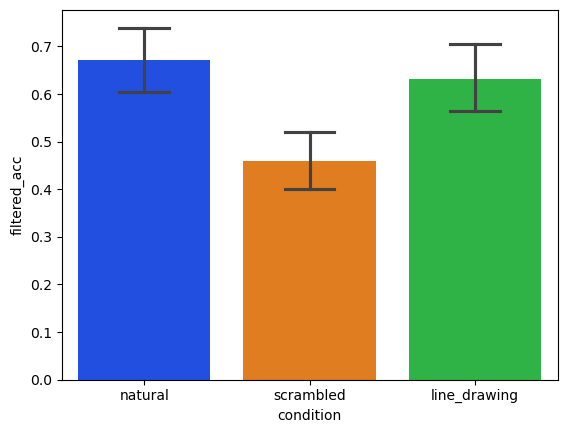

In [11]:
# Quick Visualization for debugging purposes
def plot_summary(sub_summary, extreme):
    import seaborn as sns
    import matplotlib.pyplot as plt
    if extreme == False: 
        sns.barplot(
            data=sub_summary,
            x="condition",
            y="filtered_acc",
            capsize=0.3,
            errorbar=("ci", 95),
            palette="bright",
            zorder=2,
            hue="condition"
        )
    elif extreme == True:
        sns.pointplot(
            data=sub_summary,
            x="stimulus_duration",
            y="filtered_acc",
            hue="condition",
            order=[0.3, 0.136, 0.068, 0.034],
            capsize=0.2,
            errorbar= ("ci", 95)
        )

plot_summary(sub_summary, extreme)

In [12]:
#Once visualization is complete, save the cleaned data frames
output_path = ('/zpool/vladlab/data_drive/glint_data/summary_data_csv/') #Path to save summary data CSV files

save_sub_summary(output_path=output_path)

Final cleaned sub_summary saved to /zpool/vladlab/data_drive/glint_data/summary_data_csv/novel_glint_original_cleaned.csv
Final cleaned wide-format sub_summary saved to /zpool/vladlab/data_drive/glint_data/summary_data_csv/novel_glint_original_cleaned_wide.csv
